In [4]:
import numpy as np
from scipy import signal

In [3]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [42]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)

        input_2d = input.reshape(input.shape[1], -1)
        kernels_2d = self.kernels.reshape(self.kernels.shape[0], -1)
        
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")

        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [8]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [20]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [22]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [6]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [7]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [9]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [11]:
import os
from PIL import Image, ImageOps
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn import neural_network
from sklearn import linear_model
import matplotlib.pyplot as plt

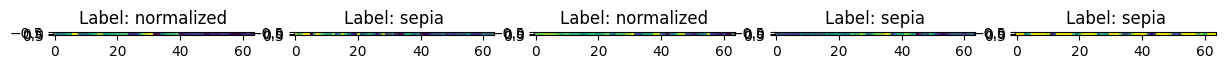

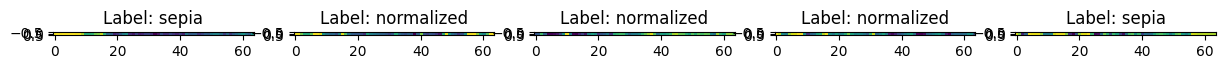

In [35]:
def data2FeaturesMoreClasses(inputs, outputs):
    labels = set(outputs)
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noData) if outputs[i] == crtLabel ]
        y = [inputs[i][1] for i in range(noData) if outputs[i] == crtLabel ]
        plt.scatter(x, y, label = outputNames[crtLabel])
    plt.xlabel('feat1')
    plt.ylabel('feat2')
    plt.legend()
    plt.show() 

def plot_samples(inputs, outputs, outputNames, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(inputs[i])  # Nu specifica cmap pentru a păstra culorile originale
        ax.set_title(f"Label: {outputNames[outputs[i]]}")

    plt.show()

def load_images_from_folders(normalized_folder, sepia_folder):
    inputs = []
    outputs = []
    outputNames = ['normalized', 'sepia']
    # Normlizate
    for filename in os.listdir(normalized_folder):
        if filename.endswith('.jpg') and 'normalized' in filename:
            img = Image.open(os.path.join(normalized_folder, filename)).resize((8, 8)).convert('L') # gri
            
            img_array = np.array(img) / 16.0
            inputs.append(img_array.reshape(1, -1))
            outputs.append(0)  # Eticheta pentru imagini normalizate

    # Sepia
    for filename in os.listdir(sepia_folder):
        if filename.endswith('.jpg') and 'sepia' in filename:
            img = Image.open(os.path.join(sepia_folder, filename)).resize((8, 8)).convert('L') # gri


            img_array = np.array(img) / 16.0
            inputs.append(img_array.reshape(1, -1))
            outputs.append(1)  # Eticheta pentru imagini cu sepia


    noData = len(inputs)
    permutation = np.random.permutation(noData)
    inputs = np.array(inputs)[permutation]
    outputs = np.array(outputs)[permutation]
    
    return inputs, outputs, outputNames

normalized_folder = 'D:/FACULTATE/SEM4/AI/Lab7/img_normalizate'
sepia_folder = 'D:/FACULTATE/SEM4/AI/Lab7/img_sepia'

inputs, outputs, outputNames = load_images_from_folders(normalized_folder, sepia_folder)

plot_samples(inputs[:5], outputs[:5], outputNames[:5])
plot_samples(inputs[-5:], outputs[-5:], outputNames[-5:])

In [13]:
def splitData(input_data, output_data):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes  if not i in trainSample]

    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]

    return trainInputs, trainOutputs, testInputs, testOutputs

In [14]:
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)

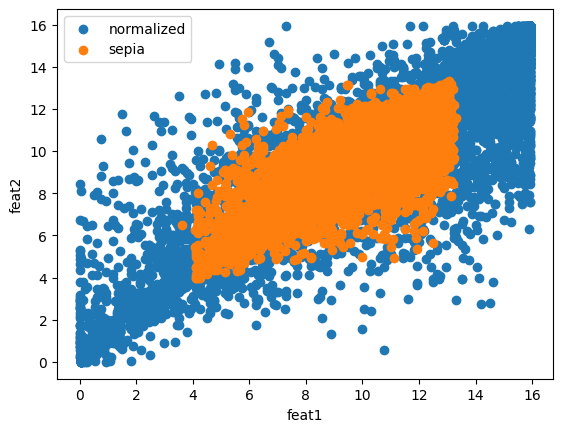

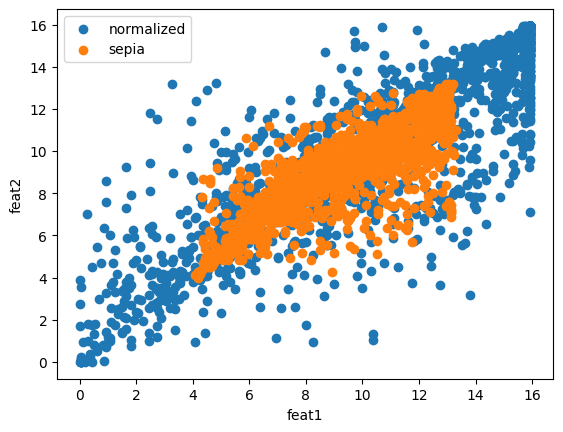

In [15]:
#train data
data2FeaturesMoreClasses(trainInputs, trainOutputs)
#test data
data2FeaturesMoreClasses(testInputs, testOutputs)

In [16]:
def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        # encode each sample into a list
        trainData = [[d] for d in trainData]
        testData = [[d] for d in testData]

        scaler.fit(trainData)  # fit only on training data
        normalisedTrainData = scaler.transform(trainData)  # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data

        # decode from list to raw values
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(trainData)  # fit only on training data
        normalisedTrainData = scaler.transform(trainData)  # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
    return normalisedTrainData, normalisedTestData

def flatten(mat):
    x = []
    for line in mat:
        for el in line:
            x.append(el)
    return x

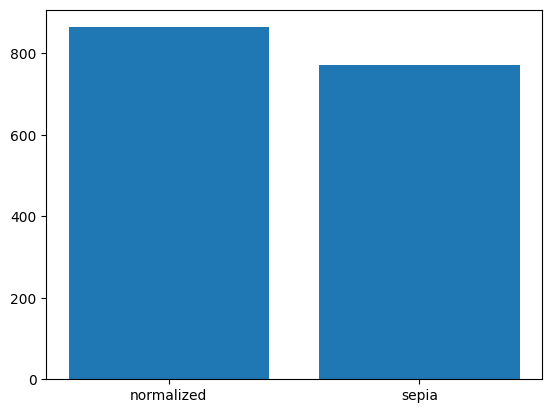

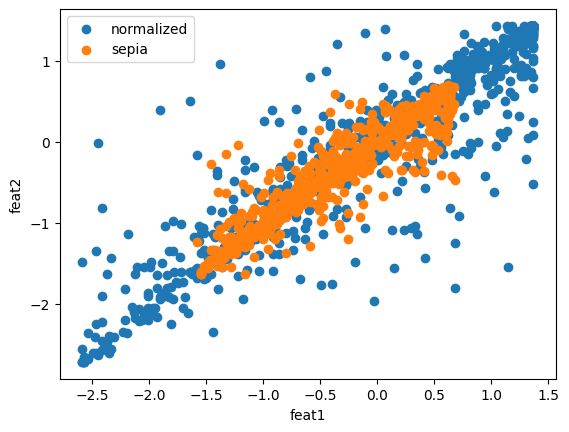

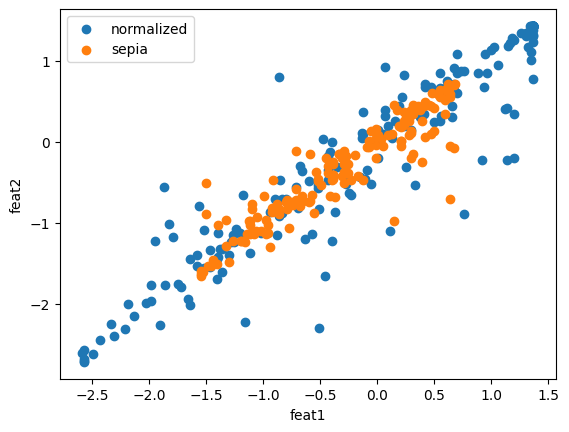

In [17]:
bins = range(len(outputNames) + 1)
plt.hist(trainOutputs, bins, rwidth=0.8)
bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
plt.xticks(np.arange(min(bins) + bin_w / 2, max(bins), bin_w), outputNames)
plt.show()


trainInputsFlatten = [flatten(el) for el in trainInputs]
testInputsFlatten = [flatten(el) for el in testInputs]

trainInputsNormalised, testInputsNormalised = normalisation(trainInputsFlatten, testInputsFlatten)

#train data normalizat
data2FeaturesMoreClasses(trainInputsNormalised, trainOutputs)
#test data noralizat
data2FeaturesMoreClasses(testInputsNormalised, testOutputs)

In [18]:
def plotConfusionMatrix(cm, classNames, title):
    from sklearn.metrics import confusion_matrix
    import itertools

    classes = classNames
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    text_format = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                 horizontalalignment='center',
                color='black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

In [43]:
model = [
    Convolutional((1, 8, 8), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

In [44]:
train(
    model,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    trainInputsNormalised,
    trainOutputs,
    epochs=20,
    learning_rate=0.1
)

IndexError: tuple index out of range